# Implementing the Vision Transformer


In this notebook, we will implement the *Vision Transformer* and test it on the small CIFAR-10 dataset. The implementation builds on elements from notebook 2 "GptFromScratch", so it is necessary to complete them in order.

We are based on the article [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929).

Here is the important figure from this article that we will implement step by step:


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Detection automatique du GPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"using device: {device}")

using device: cpu


## Reviewing Previous Code


First, we will review the code from [notebook 2 of this course](../07_Transformers/02_GptFromScratch.ipynb) with some modifications.


### Self-Attention Layer


If you recall, in notebook 2, we implemented the *masked multi-head attention* layer to train a *transformer* of the *decoder* type. For images, we want a *transformer* of the *encoder* type, so we need to change our implementation.

It's quite simple: we had a multiplication by a lower triangular matrix to mask the "future" in the *decoder*. But in the *encoder*, we don't want to mask the future, so we just need to remove this matrix multiplication.

Here is the adjusted Python code:


In [2]:
class Head_enc(nn.Module):
    """ Couche de self-attention unique """

    def __init__(self, head_size,n_embd,dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Le * C**-0.5 correspond à la normalisation par la racine de head_size
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # On a supprimer le masquage du futur
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

### Multi-Head Self-Attention


To have multiple *heads*, we will simply reuse our class from notebook 2 but using *Head_enc* instead of *Head*:


In [3]:
class MultiHeadAttention(nn.Module):
    """ Plusieurs couches de self attention en parallèle"""

    def __init__(self, num_heads, head_size,n_embd,dropout):
        super().__init__()
        # Création de num_head couches head_enc de taille head_size
        self.heads = nn.ModuleList([Head_enc(head_size,n_embd,dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### Feed Forward Layer


We also reuse our implementation of the *feed forward layer*, we just change the activation function from *ReLU* to *GeLU* as described in the article:


In [4]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd,dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

### Transformer Encoder Block


And finally, we can build our *transformer* encoder block corresponding to the one we see in the figure above:


In [5]:
class TransformerBlock(nn.Module):
    """ Block transformer"""

    def __init__(self, n_embd, n_head,dropout=0.):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size,n_embd,dropout)
        self.ffwd = FeedFoward(n_embd,dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Note**: Here, I went quickly over these layers as they were implemented in detail in notebook 2. I invite you to refer to it in case of any misunderstanding.


## Network Implementation


We will now implement the network step by step.


### Splitting the Image into Patches


The first step described in the article is the division of the image into *patches*:

Each image is divided into $N$ *patches* of size $p \times p$, then the *patches* are flattened. We go from an image dimension $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ to a sequence of *patches* $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$.


To achieve this, we will retrieve an image from the CIFAR-10 dataset as an example, which will allow us to visualize if our code works.


In [6]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.CIFAR10(root='./../data', train=True, download=True,transform=transform)

Files already downloaded and verified


Let's retrieve a simple image from this dataset for our tests:


torch.Size([3, 32, 32])


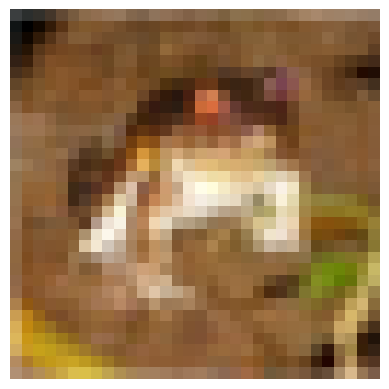

In [7]:
image=dataset[0][0]
print(image.shape)
plt.imshow(dataset[0][0].permute(1,2,0).numpy())
plt.axis("off")
plt.show()

A beautiful frog!

To choose the dimension of a *patch*, we need to take a dimension divisible by 32. Let's take $8 \times 8$ for example, which will give us 16 *patches*. Let's leave this value as a parameter that we can choose.

At first, one might think that we need to loop twice over the width and height, retrieving a *patch* each time in this way:


In [8]:
patch_size = 8
list_of_patches = []
for i in range(0,image.shape[1],patch_size):
    for j in range(0,image.shape[2],patch_size):
        patch=image[:,i:i+patch_size,j:j+patch_size]
        list_of_patches.append(patch)
tensor_patches = torch.stack(list_of_patches)
print(tensor_patches.shape)

torch.Size([16, 3, 8, 8])


This is not efficient in terms of code. With PyTorch, we can actually do it much more simply with *view()* and *unfold()*. This step is a bit complicated but necessary for memory continuity reasons so that the *view()* function works correctly. Simply doing ```patches = image.view(-1, C, patch_size, patch_size)``` would not work (you can try to verify this).


In [9]:
C,H,W = image.shape
# On utilise la fonction unfold pour découper l'image en patch contigus
# Le premier unfold découpe la première dimension (H) en ligne
# Le deuxième unfold découpe chacune des lignes en patch_size colonnes 
# Ce qui donne une image de taille (C, H//patch_size, W//patch_size,patch_size, patch_size)
patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
# Permute pour avoir les dimensions dans le bon ordre
patches = patches.permute(1, 2, 0, 3, 4).contiguous()
patches = patches.view(-1, C, patch_size, patch_size)
print(patches.shape)
# On peut vérifier que ça fait bien la même chose
print((patches==tensor_patches).all())

torch.Size([16, 3, 8, 8])
tensor(True)


Now, we will flatten our *patches* to get our final result.


In [10]:
nb_patches = patches.shape[0]
print(nb_patches)
patches_flat = patches.flatten(1, 3)
print(patches_flat.shape)

16
torch.Size([16, 192])


Let's define a function to perform these transformations:


In [11]:
# La fonction a été modifiée pour prendre en compte le batch
def image_to_patches(image, patch_size):
    # On rajoute une dimension pour le batch
    B,C,_,_ = image.shape
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0,2, 3, 1, 4, 5).contiguous()
    patches = patches.view(B,-1, C, patch_size, patch_size)
    patches_flat = patches.flatten(2, 4)
    return patches_flat


There we are! The first step is complete :)


### Linear Projection of Patches


It's time to move on to the second step, which is the linear projection of the *patches* into a latent space.


This step is equivalent to the step of converting *tokens* using the *embedding* table. This time, we will convert our flattened *patches* into vectors of fixed dimension so that these vectors can be processed by the *transformer*. Let's define our *embedding* dimension and our projection layer:


In [12]:
n_embd = 64
proj_layer = nn.Linear(C*patch_size*patch_size, n_embd)

That's all, it's not the most complicated step.


### Position Embedding and Class Token


Let's move on to the final step before the *transformer* layers (which are already implemented).

This step actually contains 2 distinct steps:
- **Adding a position embedding**: like in GPT, the *transformer* has no prior information about the position of the *patch* in the image. For this, we will simply add an *embedding* dedicated to this, which will allow the network to have a notion of the relative position of the *patches*.
- **Adding a class token**: This step is new as it was not necessary in GPT. The idea actually comes from [BERT](https://arxiv.org/pdf/1810.04805) and is a technique for performing classification using a *transformer* without having to specify a fixed sequence size. Without a *class token*, to obtain our classification, we would need either to attach a fully connected network to all the outputs of the *transformer* (which would impose a fixed sequence size), or to attach a fully connected network to an output of the *transformer* chosen at random (an output corresponds to a *patch*, but then how to choose this *patch* without bias?). Adding the *class token* allows us to address this problem by adding a *token* specifically dedicated to classification.

**Note**: For CNNs, a way to avoid the problem of the fixed input dimension is to use *global average pooling* at the output (a *pooling* layer with a fixed output size). This technique can also be used for a *vision transformer* instead of the *class token*.


In [13]:
# Pour le positional encoding, +1 pour le cls token
pos_emb = nn.Embedding(nb_patches+1, n_embd)
# On ajoute un token cls
cls_token = torch.zeros(1, 1, n_embd)
# On ajoutera ce token cls au début de chaque séquence

### Fully Connected Classification Network


Now, let's move on to the end of the ViT, i.e., the MLP classification network. If you have followed the interest of the *class token*, you understand that this classification network takes as input only this *token* to output the predicted class.

Once again, it's a fairly simple implementation. In the article, they say they use a network with one hidden layer for training and only one layer for *fine-tuning* (see course 10 for details on *fine-tuning*). For simplicity, we use a single linear layer to project the output *class token* into the dimension of the number of classes.


In [14]:
classi_head = nn.Linear(n_embd, 10)

We now have all the elements to build our ViT and train it!


### Creating the ViT Model


We can now gather the pieces and create our *vision transformer*.


In [15]:
class ViT(nn.Module):
    def __init__(self, n_embed,patch_size,C,n_head,n_layer,nb_patches,dropout=0.) -> None:
        super().__init__()
        self.proj_layer = nn.Linear(C*patch_size*patch_size, n_embed)
        self.pos_emb = nn.Embedding(nb_patches+1, n_embed)
        # Permet de créer cls_token comme un paramètre du réseau
        self.register_parameter(name='cls_token', param=torch.nn.Parameter(torch.zeros(1, 1, n_embed)))
        self.transformer=nn.Sequential(*[TransformerBlock(n_embed, n_head,dropout) for _ in range(n_layer)])
        self.classi_head = nn.Linear(n_embed, 10)
    
    def forward(self,x):
        B,_,_,_=x.shape
        # On découpe l'image en patch et on les applatit
        x = image_to_patches(x, patch_size)
        # On projette dans la dimension n_embed
        x = self.proj_layer(x)
        # On ajoute le token cls
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # On ajoute le positional encoding
        pos_emb = self.pos_emb(torch.arange(x.shape[1], device=x.device))
        x = x + pos_emb
        # On applique les blocks transformer
        x = self.transformer(x)
        # On récupère le token cls
        cls_tokens = x[:, 0]
        # On applique la dernière couche de classification
        x = self.classi_head(cls_tokens)
        return x        

## Training Our ViT


We will train our ViT model on the CIFAR-10 dataset. Note that the parameters we have defined are suitable for small-sized images (*n_embed* and *patch_size*). To process larger images, we will need to adapt these parameters. The code works with different sizes as long as the image size is divisible by the *patch* size.


### Loading the Datasets: Train, Validation, and Test


Let's load the CIFAR-10 dataset and create our *dataloaders*:

**Note**: You can select a subset of the dataset to speed up training.


In [16]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Transformation des données, normalisation et transformation en tensor pytorch
transform = T.Compose([T.ToTensor(),T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Téléchargement et chargement du dataset
dataset = datasets.CIFAR10(root='./../data', train=True,download=True, transform=transform)
testdataset = datasets.CIFAR10(root='./../data', train=False,download=True, transform=transform)
print("taille d'une image : ",dataset[0][0].shape)


#Création des dataloaders pour le train, validation et test
train_dataset, val_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
print("taille du train dataset : ",len(train_dataset))
print("taille du val dataset : ",len(val_dataset))
print("taille du test dataset : ",len(testdataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,shuffle=True, num_workers=2)
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=16,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=16,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
taille d'une image :  torch.Size([3, 32, 32])
taille du train dataset :  40000
taille du val dataset :  10000
taille du test dataset :  10000


### Hyperparameters and Model Creation


We will now define our training hyperparameters and the specifics of the model:


In [17]:
patch_size = 8
nb_patches = (32//patch_size)**2
n_embed = 64
n_head = 4
n_layer = 4
epochs = 10
C=3 # Nombre de canaux
lr = 1e-3
model = ViT(n_embed,patch_size,C,n_head,n_layer,nb_patches).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Model Training


It's finally time to train our model!


In [18]:
for epoch in range(epochs):
    model.train()
    loss_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss_train += loss.item()
        loss.backward()
        optimizer.step()
        
    model.eval()
    correct = 0
    total = 0
    loss_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_val += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch}, loss train {loss_train/len(train_loader)}, loss val {loss_val/len(val_loader)},précision {100 * correct / total}")

Epoch 0, loss train 1.6522698682546615, loss val 1.4414834783554078,précision 47.97
Epoch 1, loss train 1.3831321718215943, loss val 1.3656272639274598,précision 50.69
Epoch 2, loss train 1.271412028503418, loss val 1.2726070711135864,précision 55.17
Epoch 3, loss train 1.1935315937042237, loss val 1.2526390438556672,précision 55.52
Epoch 4, loss train 1.1144725002408027, loss val 1.2377954412460328,précision 55.66
Epoch 5, loss train 1.0520227519154548, loss val 1.2067877051830291,précision 56.82
Epoch 6, loss train 0.9839000009179115, loss val 1.2402711957931518,précision 56.93
Epoch 7, loss train 0.9204218792438507, loss val 1.2170260044574737,précision 58.23
Epoch 8, loss train 0.853291154640913, loss val 1.2737546770095824,précision 57.65
Epoch 9, loss train 0.7962572723925113, loss val 1.2941821083545684,précision 58.26


The training went well, we achieve an accuracy of 58% on the validation data. Let's now look at our results on the test data:

The accuracy is of the same order on the test data!

**Note**: This result may seem quite mediocre, but we must not forget that we are using a small *transformer* trained on few *epochs*. You can try to improve this result by adjusting the hyperparameters.

**Note2**: The authors of the paper specify that the *transformer* does not have an "inductive bias" on images unlike CNNs, and this comes from the architecture. The layers of a CNN are invariant to translation and capture the neighborhood of each pixel, while *transformers* primarily use global information. In practice, it is observed that on "small" datasets (up to 1 million images), CNNs perform better, but for larger amounts of data, *transformers* are more efficient.


In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Précision {100 * correct / total}")

Précision 58.49


La précision est du même ordre sur les données de test !

**Note** : Ce résultat peut paraître assez médiocre, mais il ne faut pas oublier qu'on utilise un petit *transformer* entraîné sur peu d'*epochs*. Vous pouvez essayer d'améliorer ce résultat en jouant sur les hyperparamètres.

**Note2** : Les auteurs du papier précisent que le *transformer* n'a pas de "inductive bias" sur les images contrairement aux CNN, et cela provient de l'architecture. Les couches d'un CNN sont invariantes par translation et capturent le voisinage de chaque pixel, tandis que les *transformers* utilisent principalement l'information globale. En pratique, on constate que sur des "petits" datasets (jusqu'à 1 million d'images), les CNN performent mieux, mais pour des plus grosses quantités de données, les *transformers* sont plus performants.
